# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.202682,False,1.194169
1,-2.930046,False,-0.099378
2,-0.176946,False,-0.365583
3,0.664866,False,-1.211488
4,-1.080623,True,5.223693
...,...,...,...
995,0.054760,False,1.203307
996,1.668404,True,2.324630
997,-1.940459,True,3.175455
998,0.160570,True,3.610299


<AxesSubplot: xlabel='v0'>

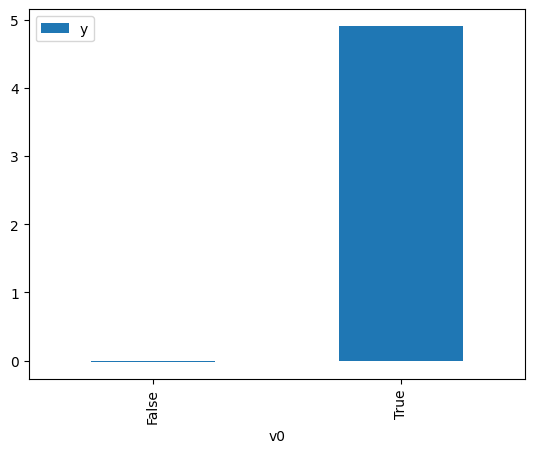

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

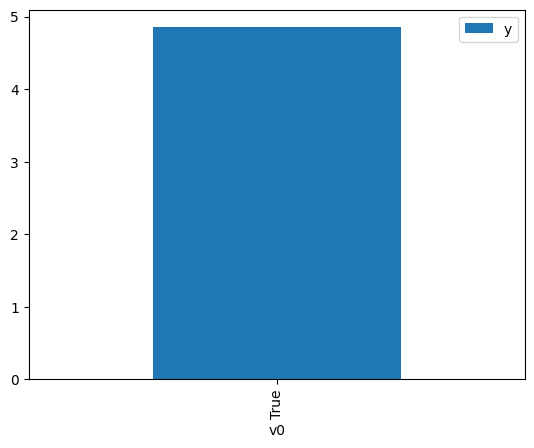

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.225989,False,-1.094190,0.557757,1.792894
1,1.029895,False,0.213633,0.258945,3.861820
2,-1.701127,False,0.441389,0.850645,1.175579
3,-1.121474,False,0.882492,0.759010,1.317506
4,-0.514958,False,-1.160197,0.628875,1.590141
...,...,...,...,...,...
995,0.350265,False,-0.753401,0.411717,2.428852
996,-0.980396,False,-0.095021,0.731663,1.366750
997,0.587032,False,-0.097019,0.354607,2.820023
998,-1.291168,False,-1.162009,0.789296,1.266952


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.148805,True,4.019603,0.235918,4.238760
1,0.024571,True,3.417077,0.506002,1.976276
2,-1.238566,True,4.151297,0.219784,4.549923
3,-1.354740,True,4.243690,0.200102,4.997451
4,-1.059235,True,3.403043,0.252816,3.955444
...,...,...,...,...,...
995,0.448819,True,3.788769,0.612443,1.632805
996,-2.110718,True,4.682417,0.103561,9.656168
997,0.373775,True,4.807342,0.594090,1.683247
998,-1.502645,True,5.453215,0.176998,5.649767


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.896
Method:                 Least Squares   F-statistic:                              4298.
Date:                Wed, 01 Feb 2023   Prob (F-statistic):                        0.00
Time:                        21:48:12   Log-Likelihood:                         -1406.6
No. Observations:                1000   AIC:                                      2817.
Df Residuals:                     998   BIC:                                      2827.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0233      0.025      0.936      0.350      -0.026       0.072
x2             4.9038      0.053     92.476      0.000       4.800       5.008
==============================================================================
Omnibus:                        3.843   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                3.783
Skew:                           0.150   Prob(JB):                        0.151
Kurtosis:                       3.022   Cond. No.                         2.14
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""